In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from textblob import TextBlob
import seaborn as sns
import numpy as np

from sklearn.utils import resample

In [4]:
nltk.download('stopwords')

pd.set_option('display.max_colwidth', 75)
pd.options.mode.chained_assignment = None

In [17]:
data = pd.read_csv('processed_data.csv', index_col = 0)
tfidf_w_sentiment = pd.read_csv('tfidf_w_sentiment.csv', index_col = 0)
raw_data = pd.read_csv('mbti_1.csv')

In [20]:
data.head(3)

,type,posts,tkns,tags,lems,lem_txt
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.co...,"['and', 'intj', 'moments', 'sportscenter', 'not', 'top', 'ten', 'plays'...","['CC', 'JJ', 'NNS', 'MD', 'RB', 'VB', 'NN', 'VBZ', 'NNS', 'WP', 'VBZ', ...","['and', 'intj', 'moment', 'sportscenter', 'not', 'top', 'ten', 'play', ...",and intj moment sportscenter not top ten play prank what have be the m...
1,ENTP,'I'm finding the lack of me in these posts very alarming.|||Sex can be ...,"['im', 'finding', 'the', 'lack', 'of', 'me', 'in', 'these', 'posts', 'v...","['NN', 'VBG', 'DT', 'NN', 'IN', 'PRP', 'IN', 'DT', 'NNS', 'RB', 'VBG', ...","['im', 'find', 'the', 'lack', 'of', 'me', 'in', 'these', 'post', 'very'...",im find the lack of me in these post very alarm sex can be boring if i...
2,INTP,'Good one _____ https://www.youtube.com/watch?v=fHiGbolFFGw|||Of cou...,"['good', 'one', 'course', 'to', 'which', 'i', 'say', 'i', 'know;', 'tha...","['JJ', 'CD', 'NN', 'TO', 'WDT', 'NNS', 'VBP', 'JJ', 'VBP', 'NNS', 'PRP$...","['good', 'one', 'course', 'to', 'which', 'i', 'say', 'i', 'know;', 'tha...",good one course to which i say i know; thats my blessing and my curse ...


In [18]:
mapper = {'anger':'anger_e',
          'fear':'fear_e',
          'joy':'joy_e',
          'love.1':'love_e',
          'sadness':'sadness_e',
          'surprise':'surprise_e'}

tfidf_w_sentiment.rename(mapper = mapper, axis = 1, inplace = True)
tfidf_w_sentiment.head()

,about,all,also,always,an,and,at,be,because,but,...,you,your,youre,label,anger_e,fear_e,joy_e,love_e,sadness_e,surprise_e
0,0.022628,0.091254,0.000000,0.027837,0.067843,0.264456,0.068314,0.374517,0.073364,0.000000,...,0.132503,0.184626,0.031418,INFJ,0.135764,0.117830,0.323762,0.081149,0.303030,0.038466
1,0.020793,0.031446,0.037442,0.025580,0.093516,0.334151,0.031388,0.394769,0.033708,0.040718,...,0.223230,0.053019,0.057743,ENTP,0.138154,0.115532,0.322613,0.088840,0.297431,0.037430
2,0.058417,0.014724,0.000000,0.053899,0.072980,0.256030,0.044092,0.455007,0.047351,0.071498,...,0.185295,0.104267,0.060834,INTP,0.129505,0.116293,0.352338,0.078601,0.282931,0.040332
3,0.062748,0.063264,0.050216,0.000000,0.031356,0.162968,0.010525,0.539645,0.045209,0.071678,...,0.173513,0.063998,0.087125,INTJ,0.145261,0.123895,0.317924,0.076562,0.293479,0.042879
4,0.031435,0.042258,0.012579,0.012891,0.031417,0.214315,0.021090,0.683529,0.045298,0.061558,...,0.163626,0.021374,0.014549,ENTJ,0.141940,0.126254,0.327624,0.075333,0.290540,0.038309


In [21]:
data.shape

(8675, 6)

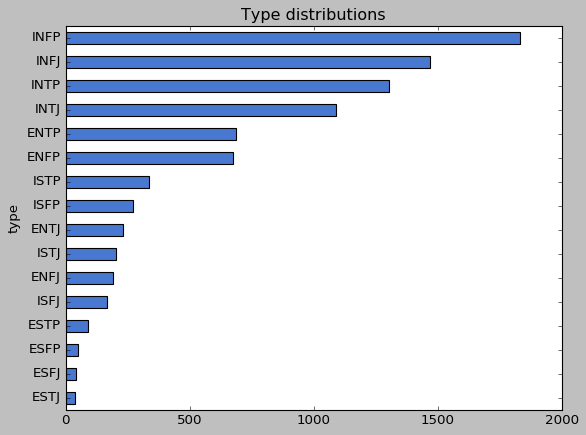

In [38]:
plt.style.use('seaborn-v0_8-muted')

data.type.value_counts(ascending = True).plot(kind = 'barh',
                                              title = 'Type distributions');

In [47]:
# Checking for empty posts
lengths = []

for post in data.posts:
    lengths.append(len(post))
    
print(min(lengths), max(lengths))

57 10090


In [48]:
data.iloc[3559]

type                                                            INFP
posts      '9, 8 and 6|||http://www.youtube.com/watch?v=Dlq6L07wxrA'
tkns                                                         ['and']
tags                                                          ['CC']
lems                                                         ['and']
lem_txt                                                          and
Name: 3559, dtype: object

# EDA

# Topic modeling

In [59]:
# Drop special characters
regex_todrop = ['[.+]','[(+]','[+)]','[+/+]','[:+:]','[+?]','[+/+]','[+~]','[+,+]',
                "[+'+]",'[+-+]','[_]']

def clean_txt(txt):
    txt = re.sub(r"\S*https?:\S*", "", txt)
    txt = re.sub(r'http\S+', "", txt)
    txt = remove_delimiters('|||', txt)
    txt = ''.join([i for i in txt if not i.isdigit()])
    for r in regex_todrop:
        txt = re.sub(r, "", txt)
    return txt

def remove_delimiters(delimiters, s):
    new_s = s
    for i in delimiters:
        new_s = new_s.replace(i, ' ')
    return ' '.join(new_s.split())

def tokenize(string):
    tkns = string.split()
    return tkns

In [ ]:
all_posts = ' '.join(data.posts)

full_text = clean_txt(all_posts).lower()

In [58]:
full_text[2000:2500]

'thing about peer pressure banned for a whole host of two baby deer on left and right munching on a beetle in the middle  using their own blood two cavemen diary todays latest happenings on their designated cave diary wall  i see it as a pokemon world an infj society everyone becomes an all artists are artists because they draw its the idea that counts in forming something of your own like a signature welcome to the robot ranks person who downed my self-esteem cuz im not an avid signature artist '

In [60]:
tkns = [w for w in tokenize(full_text) if len(w) >= 4]
tags = nltk.pos_tag(tkns)
nouns = [w for (w, tag) in tags if tag == 'NN']

In [61]:
vectorizer = TfidfVectorizer()

tfidf_topics = vectorizer.fit_transform(nouns)

topics = sorted(vectorizer.vocabulary_,
                key = lambda x: tfidf_topics[0, vectorizer.vocabulary_[x]],
                reverse = True)

In [63]:
stop_words = set(stopwords.words('english'))

In [93]:
top_100 = [t.lower() for t in topics if t not in stop_words][:100]

In [94]:
topic_freq = {}

for topic in top_100:
    topic_freq.setdefault(topic, 0)

In [95]:
posts_100 = list(data.posts[:100])

for post in posts_100:
    for topic in topic_freq.keys():
        if topic in post:
            topic_freq[topic] += 1
        else: pass

In [114]:
topics_df = pd.Series(topic_freq).to_frame().reset_index()
topics_df.columns = ['topic', 'count']
topics_df = topics_df.sort_values(by = 'count', ascending = False)
topics_df.drop(index = range(15, len(topics_df)), inplace = True)
topics_df.reset_index(drop = True, inplace = True)

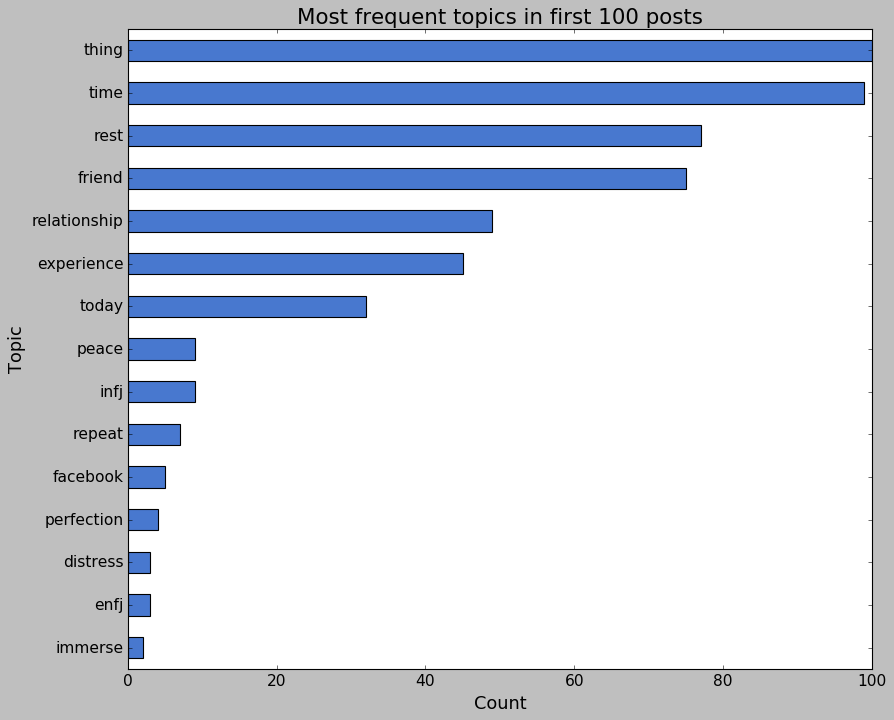

In [121]:
topics_df.sort_values(by = 'count', ascending = True, inplace = True)

plt.rcParams.update({'font.size': 16})

topics_df.plot.barh(x = 'topic', y = 'count', figsize = (12,10), fontsize = 14,
                    title = 'Most frequent topics in first 100 posts',
                    xlabel = 'Count', ylabel = 'Topic', legend = False);

# Wordcloud - ???

In [834]:
from wordcloud import WordCloud

ImportError: dlopen(/Users/ali/anaconda3/lib/python3.10/site-packages/wordcloud/query_integral_image.cpython-310-darwin.so, 0x0002): tried: '/Users/ali/anaconda3/lib/python3.10/site-packages/wordcloud/query_integral_image.cpython-310-darwin.so' (code signature in <54713B16-0612-39EA-9E5B-1B3B12B730FF> '/Users/ali/anaconda3/lib/python3.10/site-packages/wordcloud/query_integral_image.cpython-310-darwin.so' not valid for use in process: Trying to load an unsigned library), '/System/Volumes/Preboot/Cryptexes/OS/Users/ali/anaconda3/lib/python3.10/site-packages/wordcloud/query_integral_image.cpython-310-darwin.so' (no such file), '/Users/ali/anaconda3/lib/python3.10/site-packages/wordcloud/query_integral_image.cpython-310-darwin.so' (code signature in <54713B16-0612-39EA-9E5B-1B3B12B730FF> '/Users/ali/anaconda3/lib/python3.10/site-packages/wordcloud/query_integral_image.cpython-310-darwin.so' not valid for use in process: Trying to load an unsigned library)

In [ ]:
wc = WordCloud().generate(' '.join(data.posts))
plt.figure(figsize = (8,8))
plt.imshow(vis, interpolation = 'bilinear')
plt.show();

# Topic modeling by type

In [927]:
intp = data[data['type'] == 'INTP']
istp = data[data['type'] == 'ISTP']
entp = data[data['type'] == 'ENTP']
enfp = data[data['type'] == 'ENFP']
isfp = data[data['type'] == 'ISFP']
infp = data[data['type'] == 'INFP']
intj = data[data['type'] == 'INTJ']
infj = data[data['type'] == 'INFJ']
estj = data[data['type'] == 'ESTJ']
entj = data[data['type'] == 'ENTJ']
esfj = data[data['type'] == 'ESFJ']
enfj = data[data['type'] == 'ENFJ']
istj = data[data['type'] == 'ISTJ']
isfj = data[data['type'] == 'ISFJ']
estp = data[data['type'] == 'ESTP']
esfp = data[data['type'] == 'ESFP']

mbtis = ['intp','istp','entp','enfp','isfp','infp','intj','infj',
         'estj','entj','esfj','enfj','istj','isfj','estp','esfp']

posts_bytype = [intp, istp, entp, enfp, isfp, infp, intj, infj,
                estj, entj, esfj, enfj, istj, isfj, estp, esfp]

In [270]:
def get_topics(txt):
    tkns = [w for w in tokenize(txt) if len(w) >= 4]
    tags = nltk.pos_tag(tkns)
    nouns = [w for (w, tag) in tags if tag == 'NN']
    
    vectorizer = TfidfVectorizer()
    tfidf_topics = vectorizer.fit_transform(nouns)
    
    topics = sorted(vectorizer.vocabulary_,
                    key = lambda x: tfidf_topics[0, vectorizer.vocabulary_[x]],
                    reverse = True)
    return topics

def make_topics_df(topics_list, posts_list):
    topic_freq = {}
    
    for topic in topics_list[:50]:
        topic_freq.setdefault(topic, 0)
        
    for post in posts_list:
        for topic in topic_freq.keys():
            if topic in post:
                topic_freq[topic] += 1
            else: pass
    
    topics_df = pd.Series(topic_freq).to_frame().reset_index()
    topics_df.columns = ['topic', 'count']
    topics_df = topics_df.sort_values(by = 'count', ascending = True)
    topics_df.drop(index = range(15, len(topics_df)), inplace = True)
    topics_df.reset_index(drop = True, inplace = True)
    
    return topics_df[:12]

def plot_topics(topics_df, title):
    topics_df.plot.barh(x = 'topic', y = 'count', figsize = (12,8), fontsize = 14,
                        title = title, xlabel = 'Count', ylabel = 'Topic', legend = False);

In [267]:
def clean_get_plot(posts, title):
    txt = ' '.join(posts)
    txt = clean_txt(txt)
    topics = get_topics(txt)
    df = make_topics_df(topics, posts)
    plot_topics(df, title)

In [247]:
posts_to_plot = [intp.posts[:100],
                 istp.posts[:100],
                 entp.posts[:100],
                 enfp.posts[:100],
                 isfp.posts[:100],
                 infp.posts[:100],
                 intj.posts[:100],
                 infj.posts[:100],
                 estj.posts[:100],
                 entj.posts[:100],
                 esfj.posts, enfj.posts, istj.posts,
                 isfj.posts, estp.posts, esfp.posts]

In [260]:
dfs_to_plot = []

for post_set in posts_to_plot:
    txt = ' '.join(post_set)
    txt = clean_txt(txt)
    topics = get_topics(txt)
    df = make_topics_df(topics, post_set)
    dfs_to_plot.append(df)

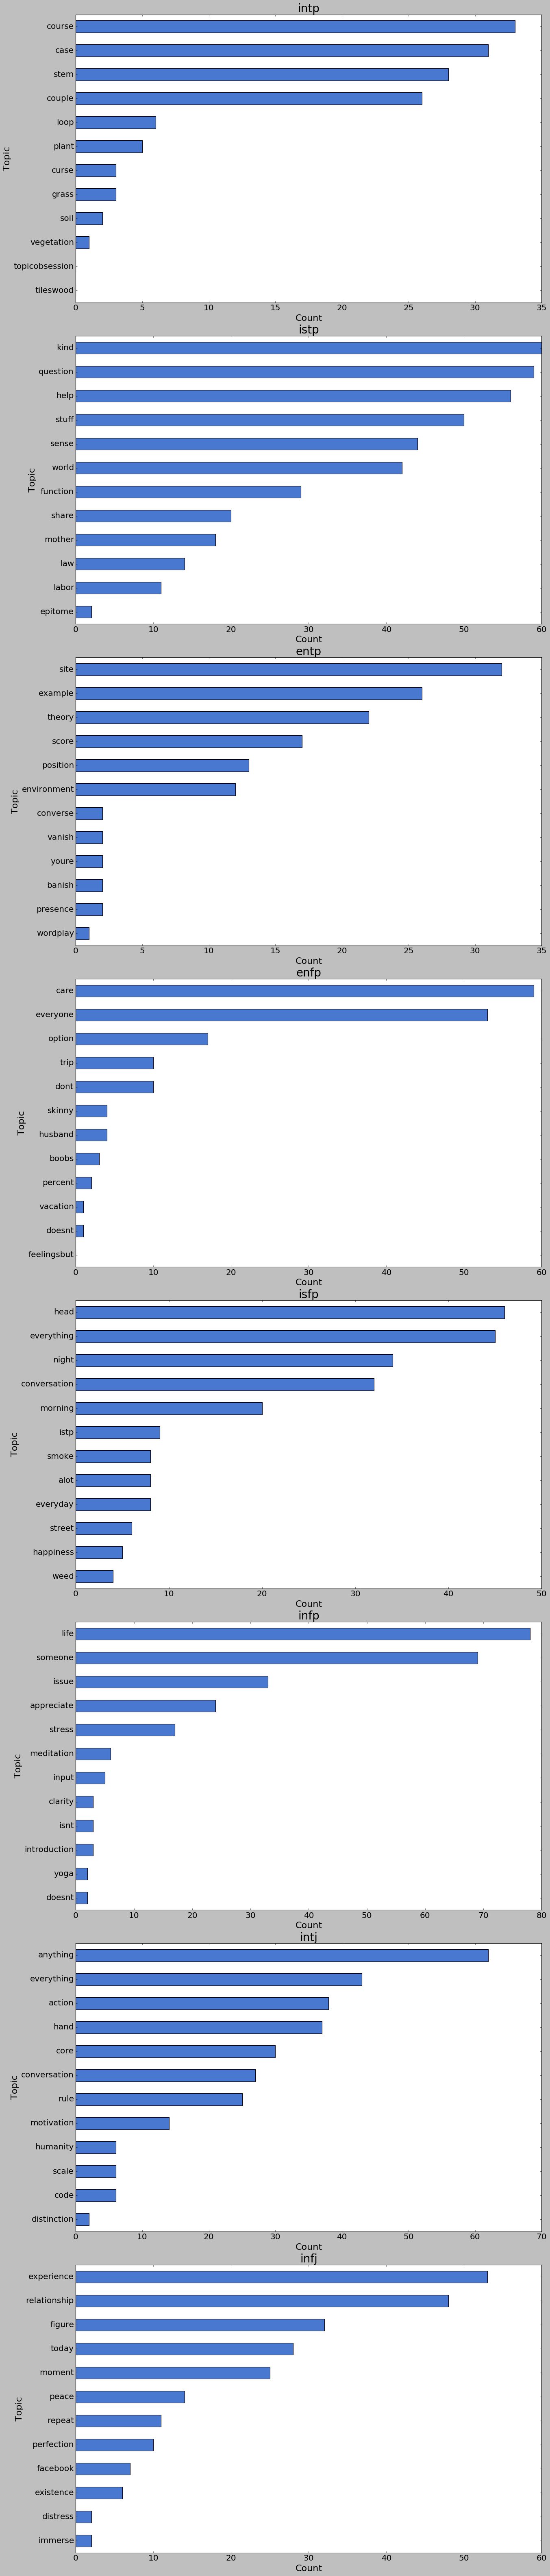

In [261]:
fig, axes = plt.subplots(8, 1, figsize = (30, 700))
fig.tight_layout(pad = 20)
# fig.suptitle('Topics by type')

plt.rcParams.update({'axes.titlesize': 25, 'axes.labelsize': 20})

count = 0
for row in range(8):
    dfs_to_plot[count].plot.barh(ax = axes[row],
                                 x = 'topic', y = 'count', figsize = (35, 80),
                                 fontsize = 18, title = mbtis[count],
                                 xlabel = 'Count', ylabel = 'Topic', legend = False)
    count += 1

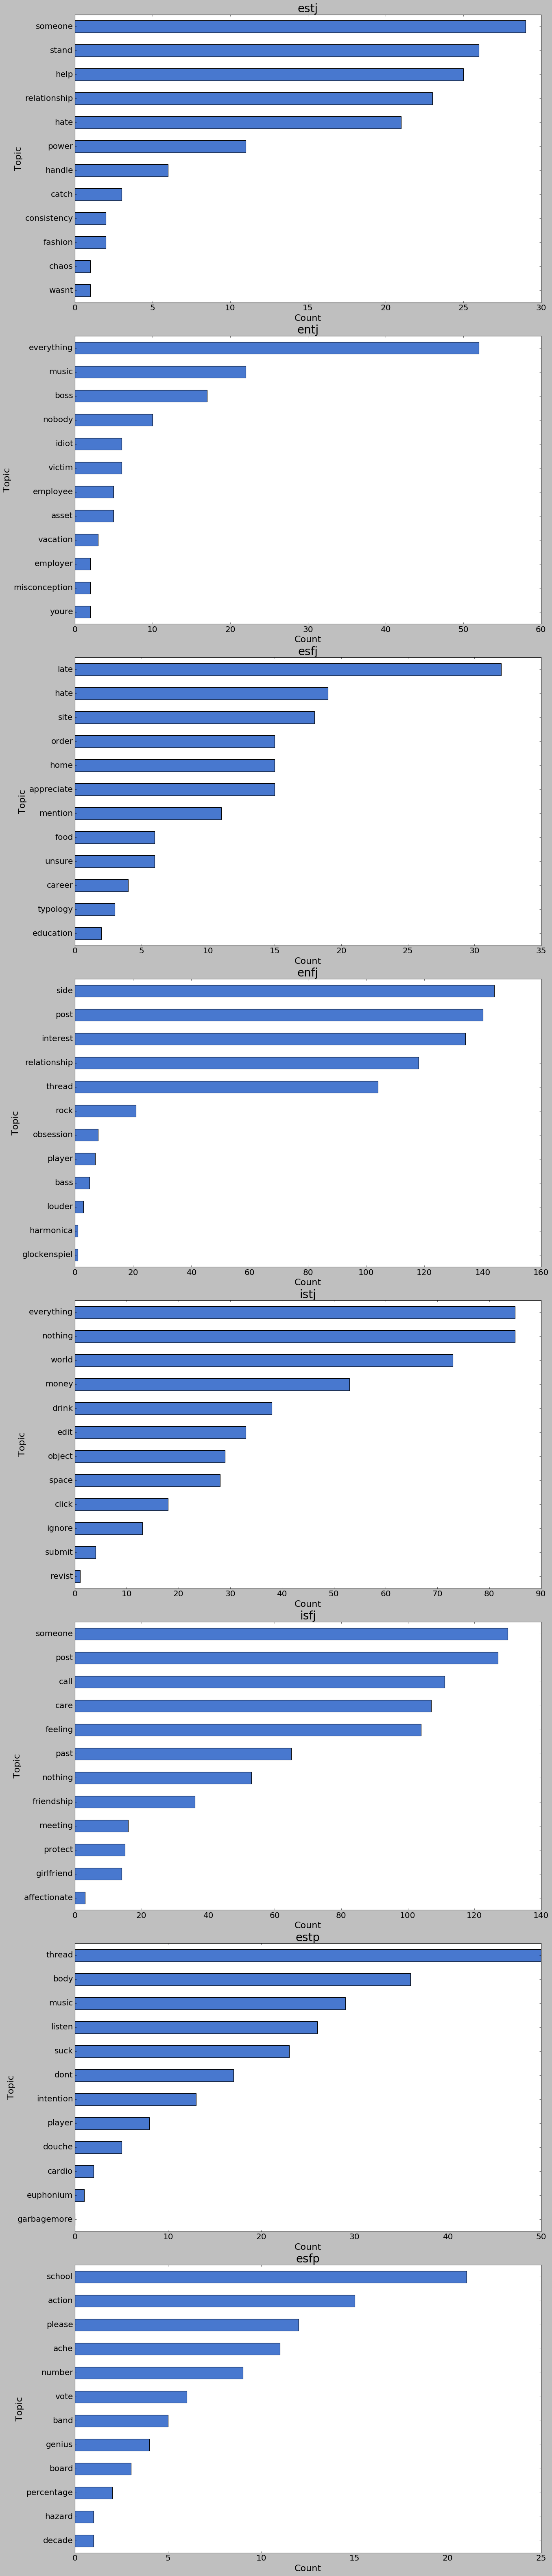

In [262]:
fig, axes = plt.subplots(8, 1, figsize = (30, 700))
fig.tight_layout(pad = 20)

count = 8
for row in range(8):
    dfs_to_plot[count].plot.barh(ax = axes[row],
                                 x = 'topic', y = 'count', figsize = (35, 80),
                                 fontsize = 18, title = mbtis[count],
                                 xlabel = 'Count', ylabel = 'Topic', legend = False)
    count += 1

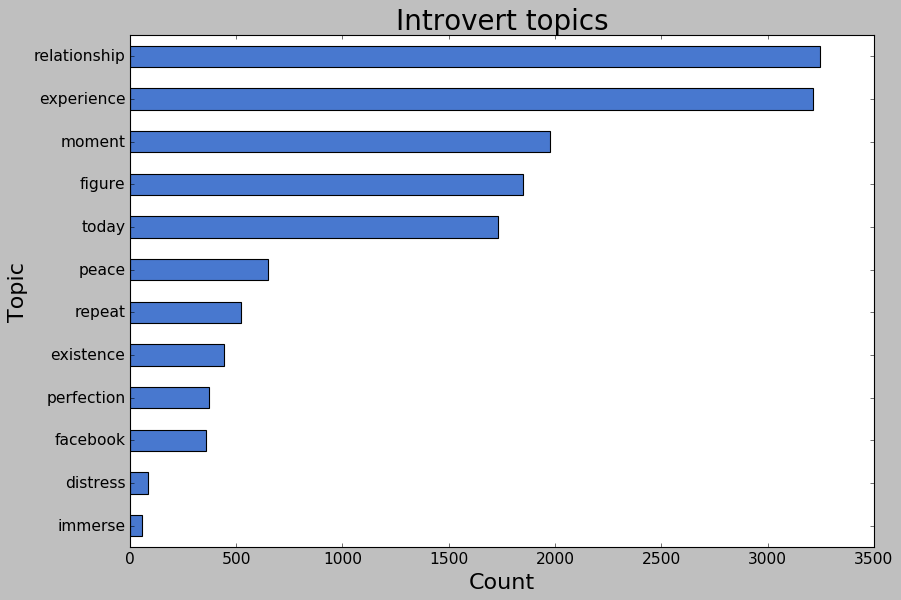

In [271]:
# Compare introvert/extravert topics
intr = data[data['type'].isin(['INFP','INFJ','INTP','INTJ','ISTP','ISFP','ISTJ','ISFJ'])]
clean_get_plot(intr.posts, 'Introvert topics')

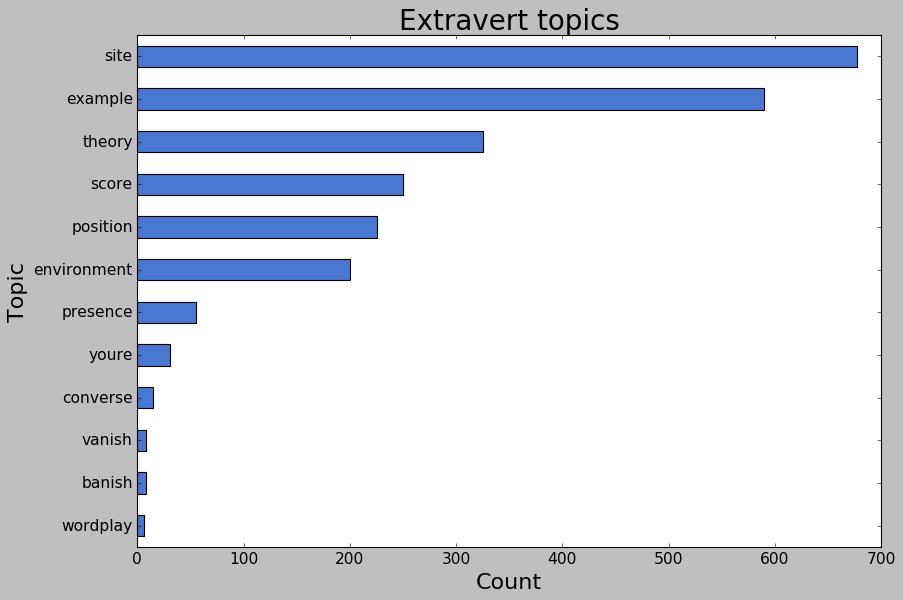

In [272]:
extr = data[data['type'].isin(['ENTP','ENFP','ENTJ','ENFJ','ESTP','ESFP','ESFJ','ESTJ'])]
clean_get_plot(extr.posts, 'Extravert topics')

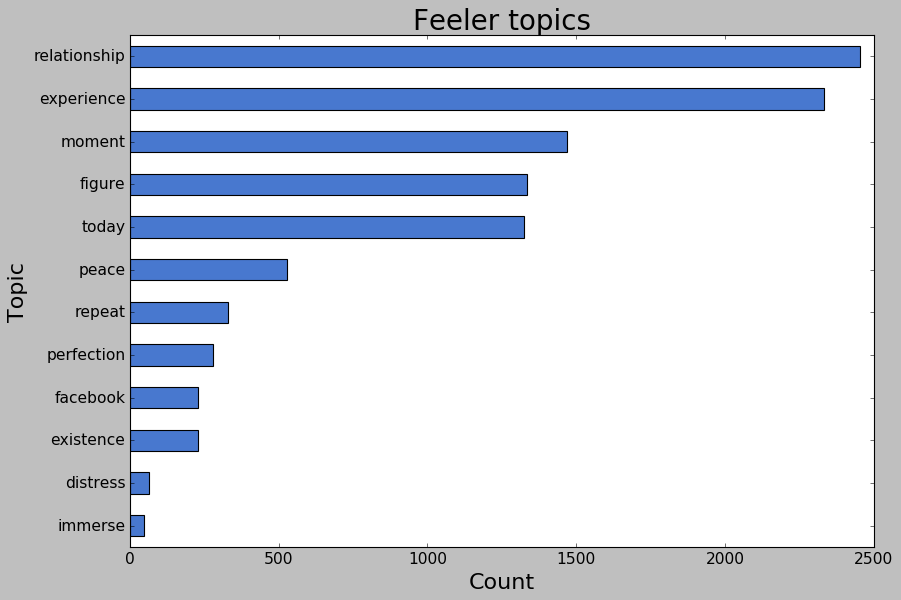

In [274]:
# Compare 'feelers' and 'thinkers'
feelers = data[data['type'].isin(['INFP','INFJ','ENFP','ISFP','ENFJ','ISFJ','ESFP','ESFJ'])]
               
clean_get_plot(feelers.posts, 'Feeler topics')

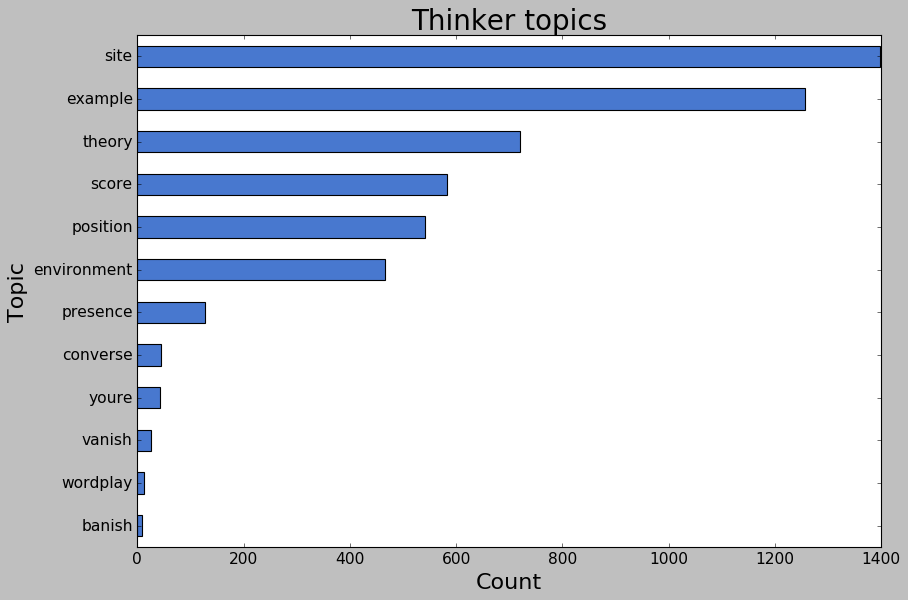

In [275]:
thinkers = data[data['type'].isin(['INTP','INTJ','ENTP','ISTP','ENTJ','ISTJ','ESTP','ESTJ'])]

clean_get_plot(thinkers.posts, 'Thinker topics')

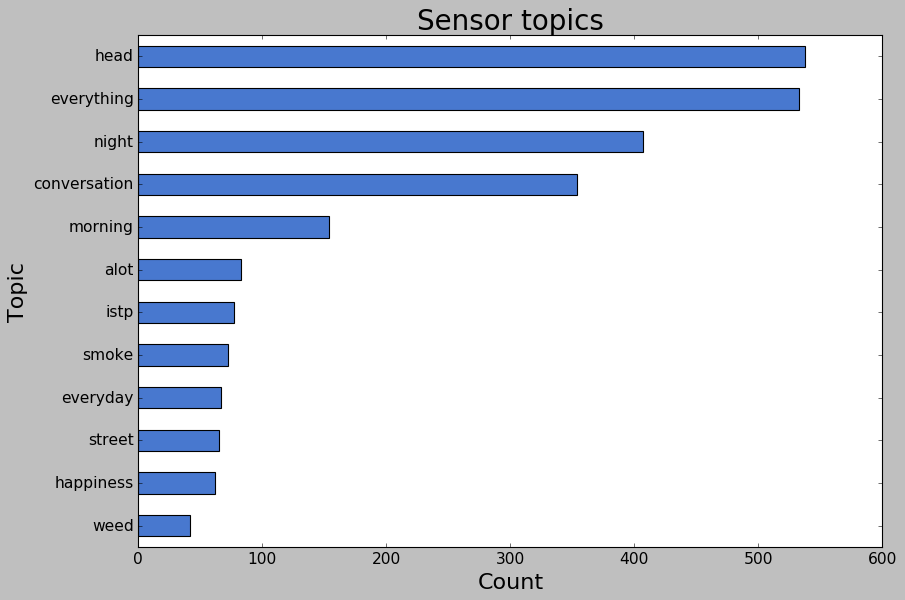

In [276]:
# Compare 'sensors' and 'intuitives'
sensors = data[data['type'].isin(['ISTP','ISFP','ISTJ','ISFJ','ESTP','ESFP','ESFJ','ESTJ'])]

clean_get_plot(sensors.posts, 'Sensor topics')

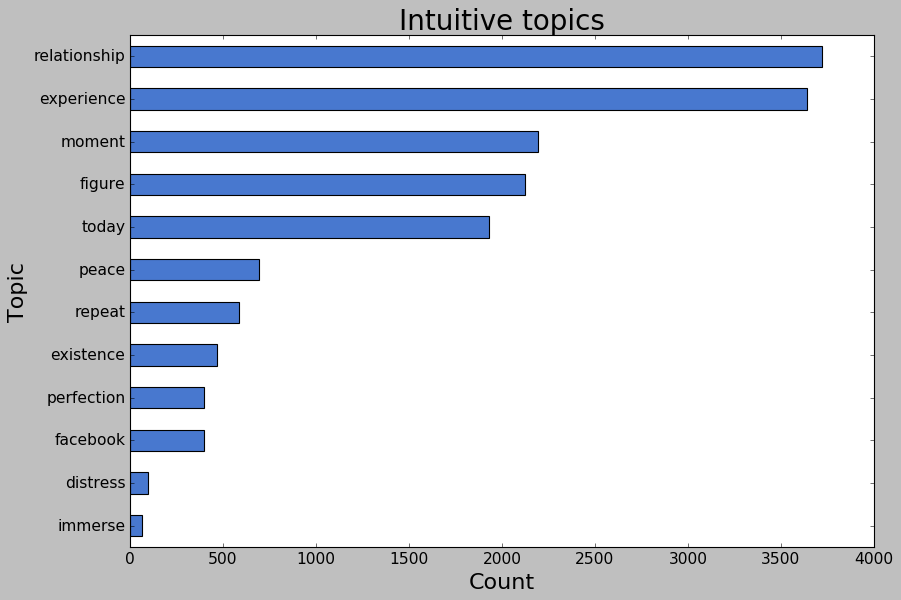

In [277]:
intuitives = data[data['type'].isin(['INFP','INFJ','INTP','INTJ','ENTP','ENFP','ENTJ','ENFJ'])]

clean_get_plot(intuitives.posts, 'Intuitive topics')

# Emotion correlation

In [340]:
emotions = ['anger_e','fear_e','joy_e','love_e','sadness_e','surprise_e']
df_corr = tfidf_w_sentiment
df_corr['label_cont'] = df_corr.label.astype('category').cat.codes

#print(df_corr.label.value_counts(), df_corr.label_cont.value_counts())

In [839]:
emotions_corr = ['anger_e','fear_e','joy_e','love_e','sadness_e','surprise_e']

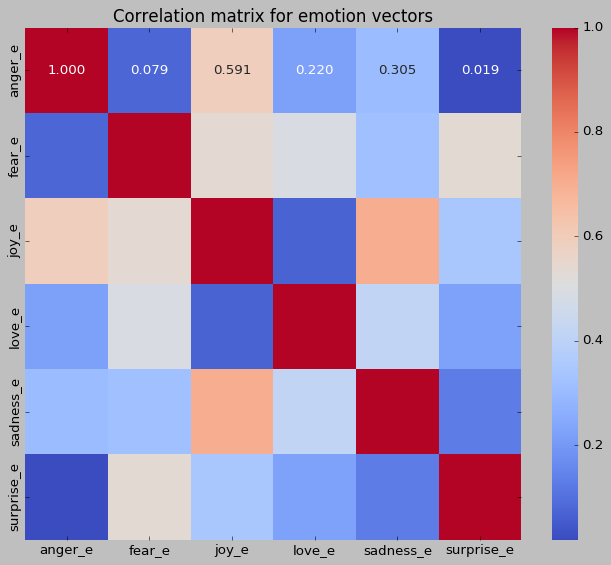

In [840]:
fig, ax = plt.subplots(figsize = (10,8))

ax = sns.heatmap(data = tfidf_w_sentiment[emotions_corr].corr(numeric_only = True).abs(),
            fmt = '.3f', cmap = 'coolwarm', annot = True)
plt.title('Correlation matrix for emotion vectors', fontsize = 15)

plt.show();

Seems emotion vectors are not really correlated to type? But the joy and sadness vectors of a post seem to correlate some (could be that these are kind of 'opposite' emotions).

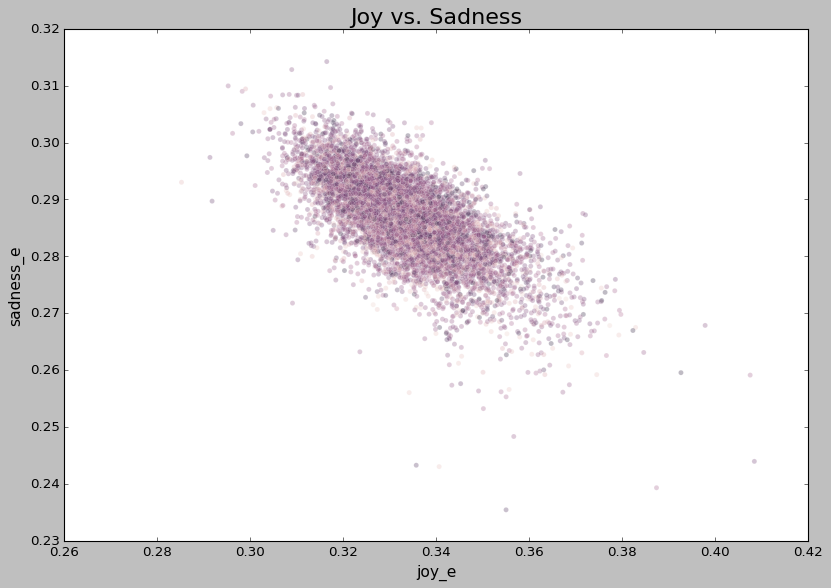

In [371]:
joy_sadness = ['joy_e', 'sadness_e']

fig, ax = plt.subplots(figsize = (12,8))

ax = sns.scatterplot(x = 'joy_e', y = 'sadness_e', alpha = .3, data = tfidf_w_sentiment,
                hue = 'label_cont', legend = False)
plt.title('Joy vs. Sadness', fontsize = 20)

plt.show();

General trend seems to be as joy increases, sadness decreases — this makes sense!

# Feature engineering

Already created "emotion" vectors for each sample.

In [280]:
tfidf_w_sentiment.head()

,about,all,also,always,an,and,at,be,because,but,...,you,your,youre,label,anger_e,fear_e,joy_e,love_e,sadness_e,surprise_e
0,0.022628,0.091254,0.000000,0.027837,0.067843,0.264456,0.068314,0.374517,0.073364,0.000000,...,0.132503,0.184626,0.031418,INFJ,0.135764,0.117830,0.323762,0.081149,0.303030,0.038466
1,0.020793,0.031446,0.037442,0.025580,0.093516,0.334151,0.031388,0.394769,0.033708,0.040718,...,0.223230,0.053019,0.057743,ENTP,0.138154,0.115532,0.322613,0.088840,0.297431,0.037430
2,0.058417,0.014724,0.000000,0.053899,0.072980,0.256030,0.044092,0.455007,0.047351,0.071498,...,0.185295,0.104267,0.060834,INTP,0.129505,0.116293,0.352338,0.078601,0.282931,0.040332
3,0.062748,0.063264,0.050216,0.000000,0.031356,0.162968,0.010525,0.539645,0.045209,0.071678,...,0.173513,0.063998,0.087125,INTJ,0.145261,0.123895,0.317924,0.076562,0.293479,0.042879
4,0.031435,0.042258,0.012579,0.012891,0.031417,0.214315,0.021090,0.683529,0.045298,0.061558,...,0.163626,0.021374,0.014549,ENTJ,0.141940,0.126254,0.327624,0.075333,0.290540,0.038309


In [455]:
# Polarity and subjectivity
TextBlob(data.posts[0]).sentiment[0]

0.1451268037518037

In [456]:
tfidf = tfidf_w_sentiment

tfidf['polarity'] = ''
tfidf['subjectivity'] = ''

for i in range(len(tfidf.index)):
    p = TextBlob(data.posts[i]).sentiment[0]
    tfidf['polarity'][i] = p
    
    s = TextBlob(data.posts[i]).sentiment[1]
    tfidf['subjectivity'][i] = s

In [519]:
tfidf.head()

,about,all,also,always,an,and,at,be,because,but,...,youre,label,anger_e,fear_e,joy_e,love_e,sadness_e,surprise_e,polarity,subjectivity
0,0.022628,0.091254,0.000000,0.027837,0.067843,0.264456,0.068314,0.374517,0.073364,0.000000,...,0.031418,INFJ,0.135764,0.117830,0.323762,0.081149,0.303030,0.038466,0.145127,0.469713
1,0.020793,0.031446,0.037442,0.025580,0.093516,0.334151,0.031388,0.394769,0.033708,0.040718,...,0.057743,ENTP,0.138154,0.115532,0.322613,0.088840,0.297431,0.037430,0.163282,0.545346
2,0.058417,0.014724,0.000000,0.053899,0.072980,0.256030,0.044092,0.455007,0.047351,0.071498,...,0.060834,INTP,0.129505,0.116293,0.352338,0.078601,0.282931,0.040332,0.174137,0.618252
3,0.062748,0.063264,0.050216,0.000000,0.031356,0.162968,0.010525,0.539645,0.045209,0.071678,...,0.087125,INTJ,0.145261,0.123895,0.317924,0.076562,0.293479,0.042879,0.114959,0.524975
4,0.031435,0.042258,0.012579,0.012891,0.031417,0.214315,0.021090,0.683529,0.045298,0.061558,...,0.014549,ENTJ,0.141940,0.126254,0.327624,0.075333,0.290540,0.038309,0.056805,0.52643


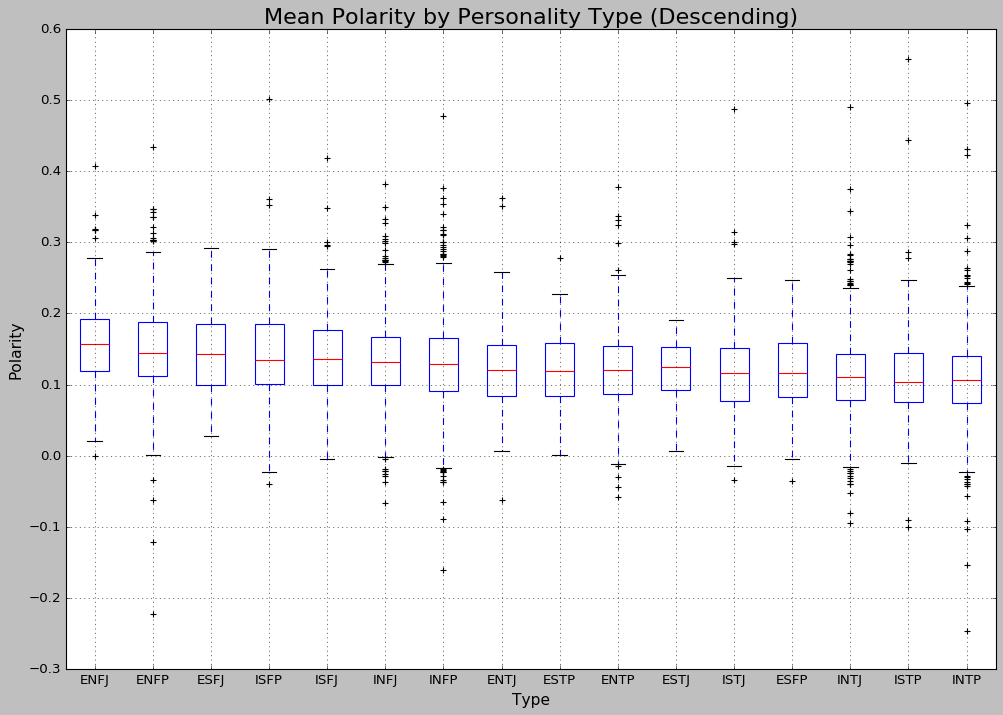

In [475]:
mbtis_cap = ['INTP','ISTP','ENTP','ENFP','ISFP','INFP','INTJ','INFJ',
             'ESTJ','ENTJ','ESFJ','ENFJ','ISTJ','ISFJ','ESTP','ESFP']

mean_polarity = [np.mean(tfidf.polarity[tfidf.label == mbti]) for mbti in mbtis_cap]

# Sort types on mean polarity, descending
sorted_indices = np.argsort(mean_polarity)[::-1]
sorted_mbtis_cap = [mbtis_cap[i] for i in sorted_indices]
sorted_mean_polarity = [mean_polarity[i] for i in sorted_indices]

# Boxplot
plt.figure(figsize=(15,10))
plt.boxplot([tfidf.polarity[tfidf.label == mbti] for mbti in sorted_mbtis_cap], labels=sorted_mbtis_cap, patch_artist=True)

plt.title('Mean Polarity by Personality Type (Descending)', fontsize = 20)
plt.xlabel('Type')
plt.ylabel('Polarity')
plt.ylim(-0.3, 0.6)

plt.grid(True)
plt.show();

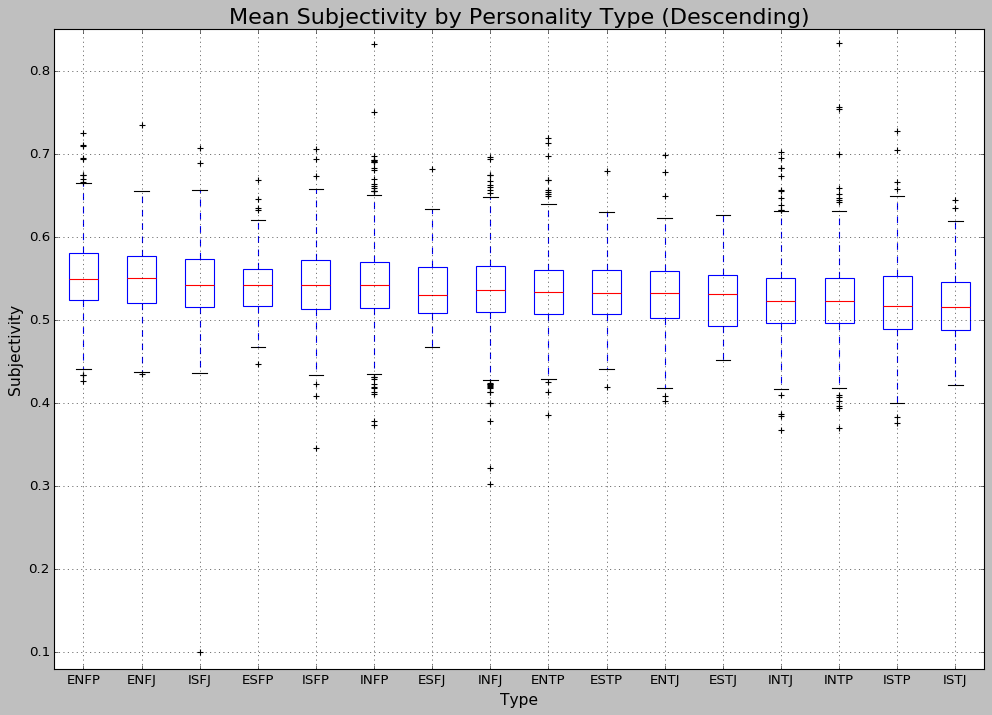

In [488]:
mean_subjectivity = [np.mean(tfidf.subjectivity[tfidf.label == mbti]) for mbti in mbtis_cap]

# Sort types on mean polarity, descending
sorted_indices = np.argsort(mean_subjectivity)[::-1]
sorted_mbtis_cap = [mbtis_cap[i] for i in sorted_indices]
sorted_mean_subjectivity = [mean_subjectivity[i] for i in sorted_indices]

# Boxplot
plt.figure(figsize=(15,10))
plt.boxplot([tfidf.subjectivity[tfidf.label == mbti] for mbti in sorted_mbtis_cap], labels=sorted_mbtis_cap, patch_artist=True)

plt.title('Mean Subjectivity by Personality Type (Descending)', fontsize = 20)
plt.xlabel('Type')
plt.ylabel('Subjectivity')
plt.ylim(0.08, 0.85)

plt.grid(True)
plt.show();

In [508]:
outlier = tfidf.subjectivity[tfidf.label == 'ISFJ'].min()
tfidf[tfidf.subjectivity == outlier]
print(data.posts.iloc[5831])
print(data.lem_txt.iloc[5831])

 forward to my meeting with the board of health make me laugh so


Drop this sample? Mostly just URLs, one line of actual text. Affects subjectivity but not much else...

# One-hot encoding

In [858]:
encoded_label_df = pd.get_dummies(tfidf.label) * 1.0
tfidf_hot = pd.concat([tfidf, encoded_label_df], axis = 1)

tfidf_hot.head()

,about,all,also,always,an,and,at,be,because,but,...,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
0,0.022628,0.091254,0.000000,0.027837,0.067843,0.264456,0.068314,0.374517,0.073364,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.020793,0.031446,0.037442,0.025580,0.093516,0.334151,0.031388,0.394769,0.033708,0.040718,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.058417,0.014724,0.000000,0.053899,0.072980,0.256030,0.044092,0.455007,0.047351,0.071498,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.062748,0.063264,0.050216,0.000000,0.031356,0.162968,0.010525,0.539645,0.045209,0.071678,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.031435,0.042258,0.012579,0.012891,0.031417,0.214315,0.021090,0.683529,0.045298,0.061558,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [910]:
tfidf_hot.iloc[:,-16:]

,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8670,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8671,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Random Forest feature importance

In [911]:
from sklearn.model_selection import train_test_split

#cols_todrop = mbtis_cap + ['label']

X = tfidf.drop('label', axis = 1)
y = tfidf_hot.iloc[:,-16:]

# Actual train and test sets (test data will not be used now)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y,
                                                    random_state = 17 )

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6506, 108) (2169, 108) (6506, 16) (2169, 16)


In [860]:
from sklearn.ensemble import RandomForestClassifier

# Initialize classifier
rf_eda = RandomForestClassifier(random_state = 17, n_jobs = -1)

In [918]:
# Lazy - rough split into rf train/val sets
rf_X_train = X_train[:5200].reset_index(drop = True)
rf_y_train = y_train[:5200].apply(lambda x: x.idxmax(), axis = 1).reset_index(drop = True)
rf_X_val = X_train[5200:].reset_index(drop = True)
rf_y_val = y_train[5200:].apply(lambda x: x.idxmax(), axis = 1).reset_index(drop = True)

rf_X_train.shape, rf_y_train.shape, rf_X_val.shape, rf_y_val.shape

((5200, 108), (5200,), (1306, 108), (1306,))

In [919]:
# Fit classifier to training data
rf1 = rf_eda.fit(rf_X_train, rf_y_train)

# Score
print(f"Accuracy on train set: {rf1.score(rf_X_train, rf_y_train):.3f}")
print(f"Accuracy on validation set: {rf1.score(rf_X_val, rf_y_val):.3f}")

Accuracy on train set: 1.000
Accuracy on validation set: 0.264


In [921]:
y_pred = rf1.predict(rf_X_val)
pd.Series(y_pred).value_counts()

INFP    603
INTP    279
INFJ    273
INTJ    134
ENTP     11
ENFP      6
Name: count, dtype: int64

In [1093]:
tfidf.label.value_counts(ascending = False)

label
INFP    1832
INFJ    1470
INTP    1304
INTJ    1091
ENTP     685
ENFP     675
ISTP     337
ISFP     271
ENTJ     231
ISTJ     205
ENFJ     190
ISFJ     166
ESTP      89
ESFP      48
ESFJ      42
ESTJ      39
Name: count, dtype: int64

Huge class imbalance problem, need to resample. Average value count is 542.

# Downsampling & Upsampling

In [1213]:
# Selecting samples to be removed
infp_down = resample(infp, replace = False, n_samples = int(0.6 * len(infp)), random_state = 17)
infj_down = resample(infj, replace = False, n_samples = int(0.6 * len(infj)), random_state = 17)
intp_down = resample(intp, replace = False, n_samples = int(0.6 * len(intp)), random_state = 17)
intj_down = resample(intj, replace = False, n_samples = int(0.6 * len(intj)), random_state = 17)

entp_down = resample(entp, replace = False, n_samples = int(0.2 * len(entp)), random_state = 17)
enfp_down = resample(enfp, replace = False, n_samples = int(0.2 * len(enfp)), random_state = 17)

estj_up = resample(estj, replace = True, n_samples = int(10 * len(estj)), random_state = 17)
esfj_up = resample(esfj, replace = True, n_samples = int(10 * len(esfj)), random_state = 17)
esfp_up = resample(esfp, replace = True, n_samples = int(10 * len(esfp)), random_state = 17)

estp_up = resample(estp, replace = True, n_samples = int(5 * len(estp)), random_state = 17)

isfj_up = resample(isfj, replace = True, n_samples = int(2.5 * len(isfj)), random_state = 17)
enfj_up = resample(enfj, replace = True, n_samples = int(2.5 * len(enfj)), random_state = 17)
istj_up = resample(istj, replace = True, n_samples = int(2 * len(istj)), random_state = 17)
entj_up = resample(entj, replace = True, n_samples = int(2 * len(entj)), random_state = 17)

isfp_up = resample(isfp, replace = True, n_samples = int(0.5 * len(isfp)), random_state = 17)
istp_up = resample(istp, replace = True, n_samples = int(0.5 * len(istp)), random_state = 17)

downsample = [infp_down, infj_down, intp_down, intj_down, entp_down, enfp_down]
upsample = [estj_up, esfj_up, esfp_up, estp_up, isfj_up, enfj_up, istj_up, entj_up,
            isfp_up, istp_up]

# Balanced tfidf
tfidf_bal = pd.concat([tfidf, encoded_label_df], axis = 1)

for x in downsample:
    tfidf_bal = tfidf_bal[~tfidf_bal.index.isin(x.index)]
    
up_samples = []    

for x in upsample:
    for i in x.index:
        new_sample = tfidf_bal.loc[i]
        up_samples.append(new_sample)

up_samples = pd.DataFrame(up_samples)
tfidf_bal = pd.concat([tfidf_bal, up_samples], axis = 0, ignore_index = True)

# tfidf_bal.iloc[:,-25:].head()
tfidf_bal.label.value_counts()

label
INFP    733
ENTJ    693
ENFJ    665
ISTJ    615
INFJ    588
ISFJ    581
ENTP    548
ENFP    540
ESTP    534
ESFP    528
INTP    522
ISTP    505
ESFJ    462
INTJ    437
ESTJ    429
ISFP    406
Name: count, dtype: int64

In [1250]:
X = tfidf_bal.drop(['label'] + mbtis_cap, axis = 1)
y = tfidf_bal.iloc[:,-16:]

class_names = tfidf_bal.columns[-16:]

# Train and test sets, downsampled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, stratify = y,
                                                    random_state = 17 )

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6589, 108), (2197, 108), (6589, 16), (2197, 16))

In [1251]:
# Rough split
rf_X_train = X_train[:5500].reset_index(drop = True)
rf_y_train = y_train[:5500].apply(lambda x: x.idxmax(), axis = 1).reset_index(drop = True)
rf_X_val = X_train[5500:].reset_index(drop = True)
rf_y_val = y_train[5500:].apply(lambda x: x.idxmax(), axis = 1).reset_index(drop = True)

# rf_X_train.shape, rf_y_train.shape, rf_X_val.shape, rf_y_val.shape

rf1 = rf_eda.fit(rf_X_train, rf_y_train)

print(f"Accuracy on train set: {rf1.score(rf_X_train, rf_y_train):.4f}")
print(f"Accuracy on test set: {rf1.score(rf_X_val, rf_y_val):.4f}")

Accuracy on train set: 1.0000
Accuracy on test set: 0.5813


In [1252]:
y_pred = rf1.predict(rf_X_val)
pd.Series(y_pred).value_counts()

INFP    172
ENTJ     91
ENFJ     84
ISFJ     76
INTP     76
ISTJ     75
ENTP     72
ESFP     70
ESTP     68
ENFP     61
INFJ     59
ESTJ     56
ISTP     41
ESFJ     40
INTJ     27
ISFP     21
Name: count, dtype: int64

In [1253]:
probs = rf1.predict_proba(rf_X_val)
probs_array = np.array(probs)

pred_probs_df = pd.DataFrame(probs_array, columns = class_names)
pred_probs_df['y_pred'] = y_pred
pred_probs_df['true'] = rf_y_val
pred_probs_df

,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,y_pred,true
0,0.87,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.02,0.03,0.02,0.03,0.00,0.00,0.00,0.00,ENFJ,ENFJ
1,0.06,0.10,0.08,0.02,0.00,0.00,0.02,0.05,0.14,0.16,0.05,0.08,0.09,0.04,0.05,0.06,INFP,INTP
2,0.02,0.03,0.01,0.02,0.01,0.04,0.00,0.01,0.03,0.03,0.01,0.02,0.66,0.05,0.01,0.05,ISFJ,ISFJ
3,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,ESFP,ESFP
4,0.09,0.09,0.07,0.09,0.02,0.00,0.01,0.03,0.14,0.11,0.09,0.01,0.07,0.06,0.06,0.06,INFJ,INFP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.95,0.01,0.02,0.00,ISFJ,ISFJ
1085,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.00,0.02,0.91,0.01,0.00,0.02,ISFJ,ISFJ
1086,0.07,0.05,0.11,0.04,0.04,0.06,0.03,0.03,0.08,0.08,0.04,0.06,0.04,0.07,0.08,0.12,ISTP,INFP
1087,0.08,0.07,0.08,0.11,0.01,0.01,0.00,0.01,0.15,0.08,0.13,0.05,0.05,0.04,0.07,0.06,INFJ,ENTP


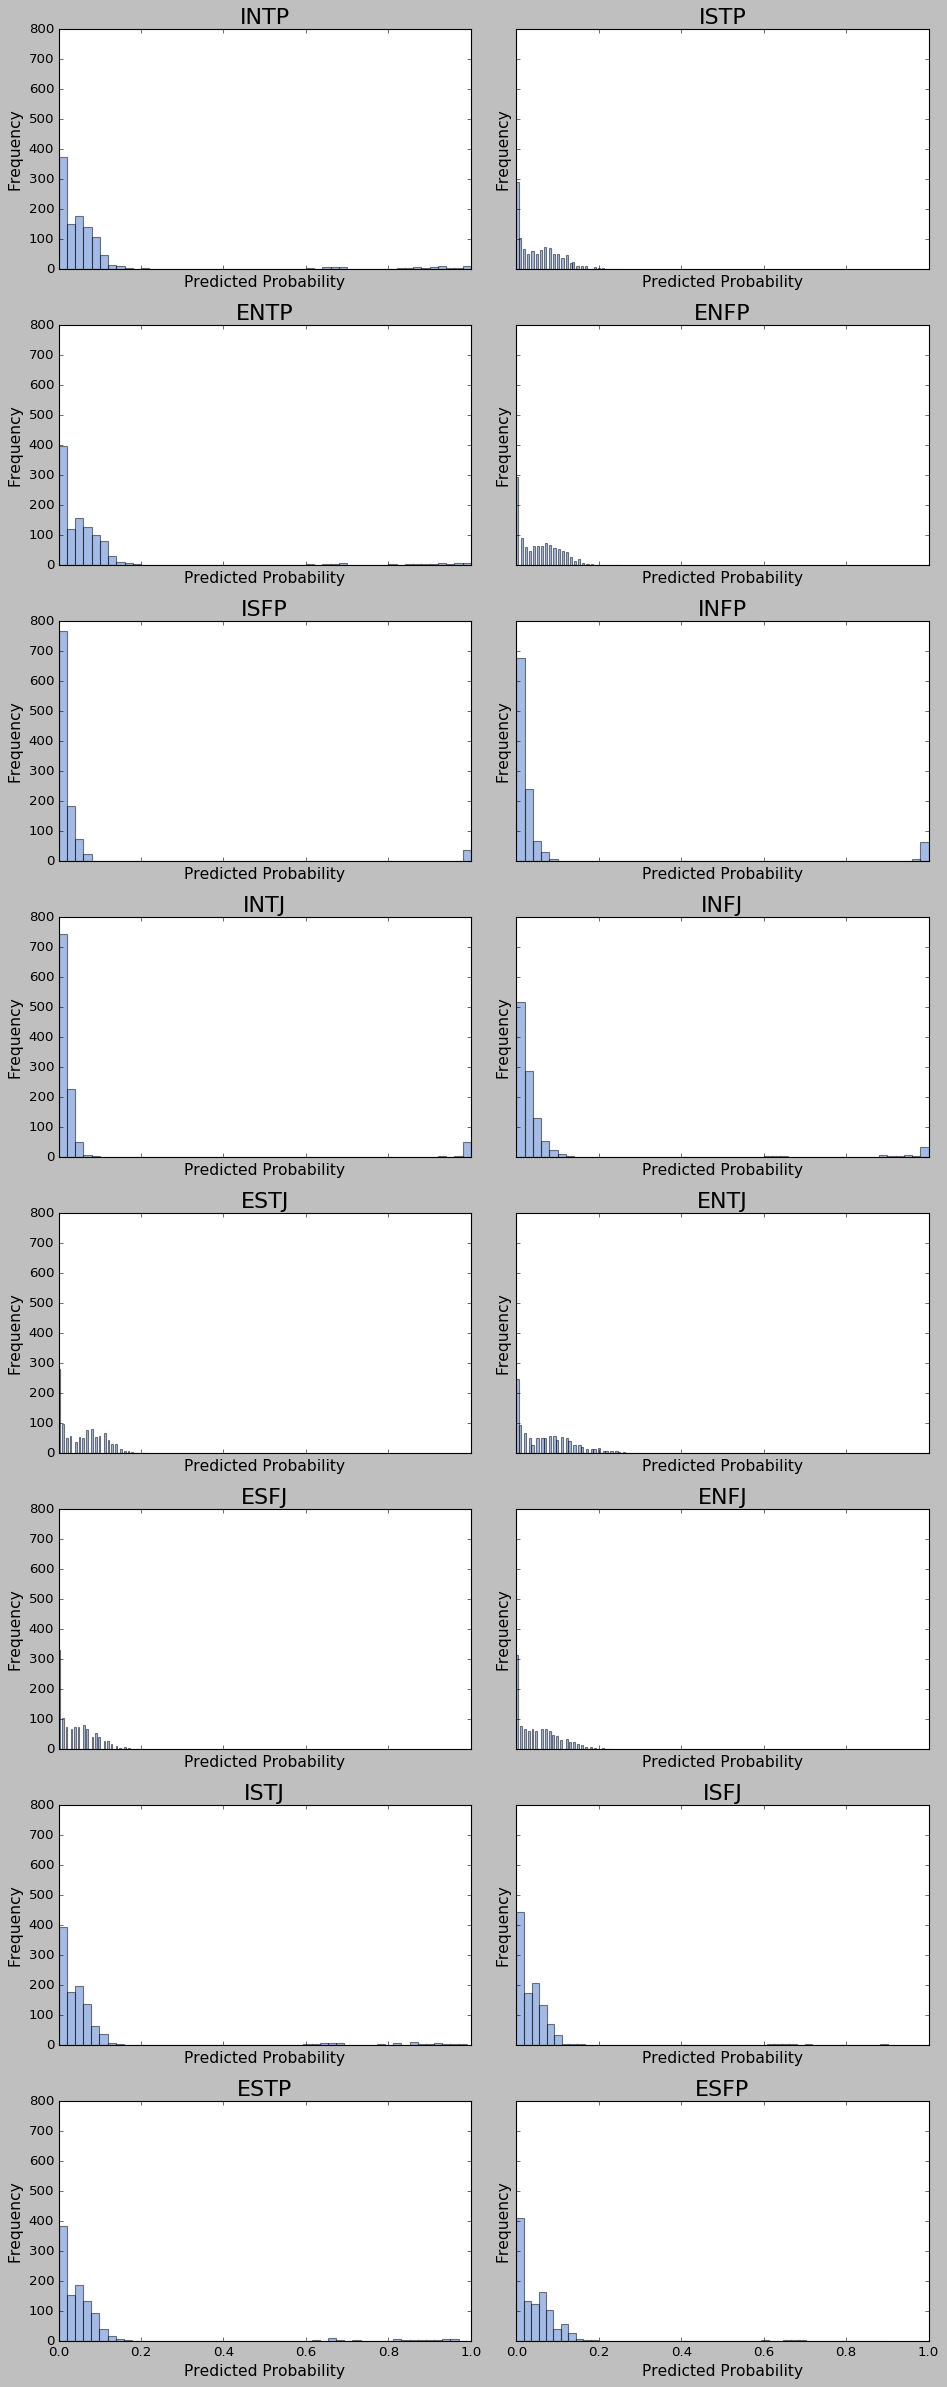

In [1254]:
fig, axs = plt.subplots(nrows = 8, ncols = 2, figsize = (12,30),
                        sharex = True, sharey = True)

# Plot histograms of predicted probabilities for each class
for i, ax in enumerate(axs.flat):
    ax.hist(probs_array[:, i], bins = 50, alpha = 0.5)
    ax.set_title(mbtis_cap[i], fontsize = 20)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

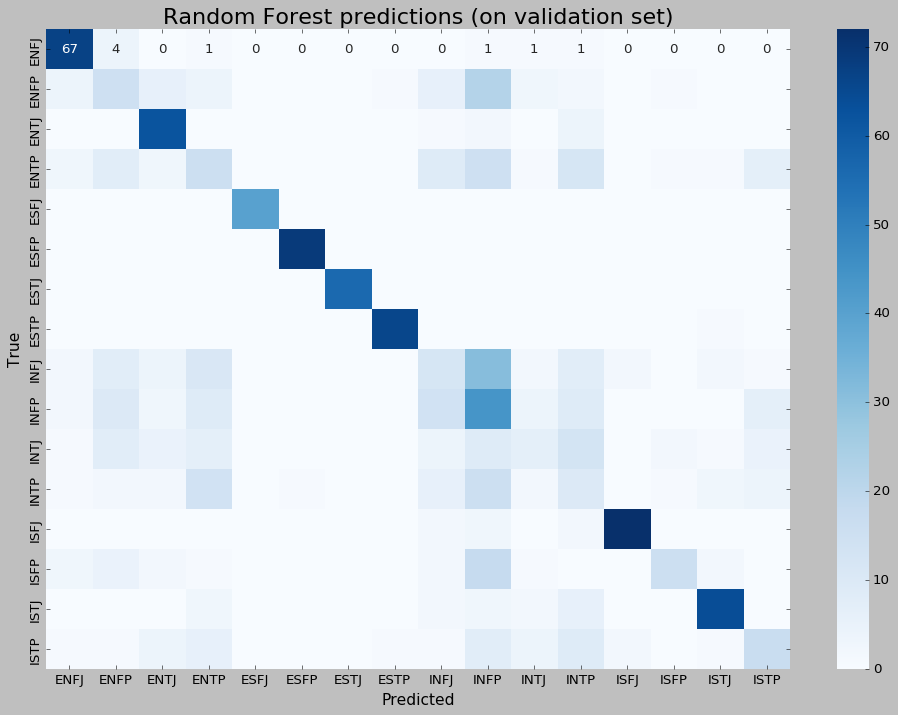

In [1255]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(rf_y_val, y_pred)

plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'g',
            xticklabels = class_names, yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest predictions (on validation set)', fontsize = 20)
plt.show()

In [1256]:
rf_rep_dict = classification_report(rf_y_val, y_pred, output_dict = True)
rf_rep = pd.DataFrame(rf_rep_dict)
rf_rep = rf_rep.round(decimals = 2)
rf_rep.columns = list(class_names) + ['accuracy','macro avg','weighted avg']
#rf_rep['class'] = mbtis_cap + ['accuracy','macro avg','weighted avg']
#rf_rep.set_index('class', inplace = True)
rf_rep

,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,accuracy,macro avg,weighted avg
precision,0.80,0.25,0.68,0.22,1.0,0.99,1.0,0.97,0.20,0.26,0.26,0.13,0.95,0.76,0.85,0.41,0.58,0.61,0.59
recall,0.89,0.23,0.90,0.21,1.0,1.00,1.0,0.99,0.14,0.43,0.11,0.16,0.91,0.32,0.80,0.31,0.58,0.59,0.58
f1-score,0.84,0.24,0.78,0.22,1.0,0.99,1.0,0.98,0.17,0.32,0.16,0.14,0.93,0.45,0.83,0.35,0.58,0.59,0.57
support,75.00,64.00,69.00,76.00,40.0,69.00,56.0,67.00,83.00,102.00,62.00,62.00,79.00,50.00,80.00,55.00,0.58,1089.00,1089.00


In [1316]:
# Calculating ideal test size? (for EDA)
for i in np.linspace(0.05, .5, 20):
    rf_X_train2, rf_X_val2, rf_y_train2, rf_y_val2 = train_test_split(X_train, y_train,
                                                                      test_size = i,
                                                                      stratify = y_train,
                                                                      random_state = 17)
    rf2 = rf_eda.fit(rf_X_train2, rf_y_train2)
    print("test_size =", i, f"Accuracy on train set: {rf2.score(rf_X_train2, rf_y_train2):.4f}")
    print("test_size =", i, f"Accuracy on validation set: {rf2.score(rf_X_val2, rf_y_val2):.4f}")

test_size = 0.05 Accuracy on train set: 0.9994
test_size = 0.05 Accuracy on validation set: 0.5152
test_size = 0.0736842105263158 Accuracy on train set: 0.9998
test_size = 0.0736842105263158 Accuracy on validation set: 0.5206
test_size = 0.09736842105263158 Accuracy on train set: 0.9995
test_size = 0.09736842105263158 Accuracy on validation set: 0.5156
test_size = 0.12105263157894737 Accuracy on train set: 0.9995
test_size = 0.12105263157894737 Accuracy on validation set: 0.5138
test_size = 0.14473684210526316 Accuracy on train set: 0.9995
test_size = 0.14473684210526316 Accuracy on validation set: 0.5073
test_size = 0.16842105263157897 Accuracy on train set: 0.9998
test_size = 0.16842105263157897 Accuracy on validation set: 0.4964
test_size = 0.19210526315789472 Accuracy on train set: 0.9994
test_size = 0.19210526315789472 Accuracy on validation set: 0.4945
test_size = 0.21578947368421053 Accuracy on train set: 0.9998
test_size = 0.21578947368421053 Accuracy on validation set: 0.4887


In [1321]:
# Try validating again with real train_test_split
rf_X_train2, rf_X_val2, rf_y_train2, rf_y_val2 = train_test_split(X_train, y_train,
                                                                  test_size = .08,
                                                                  stratify = y_train,
                                                                  random_state = 17)

# print(rf_X_train2.shape, rf_X_val2.shape, rf_y_train2.shape, rf_y_val2.shape)

rf2 = rf_eda.fit(rf_X_train2, rf_y_train2)
    
print(f"Accuracy on train set: {rf2.score(rf_X_train2, rf_y_train2):.4f}")
print(f"Accuracy on validation set: {rf2.score(rf_X_val2, rf_y_val2):.4f}")

# pd.Series(np.argmax(rf_y_train2, axis = 1)).value_counts()

Accuracy on train set: 0.9997
Accuracy on validation set: 0.5208


Accuracy on train set: 0.9997
Accuracy on validation set: 0.5208


Satisfactory for feature importance analysis?

In [1322]:
y_pred2 = rf2.predict(rf_X_val2)
y_pred2 = np.argmax(y_pred2, axis=1)
y_true2 = np.argmax(rf_y_val2, axis=1)

pd.Series(y_pred2).value_counts()

0     289
2      37
5      32
7      32
12     31
14     31
4      28
6      26
15     12
13     10
Name: count, dtype: int64

Why so many ENFJ predictions?

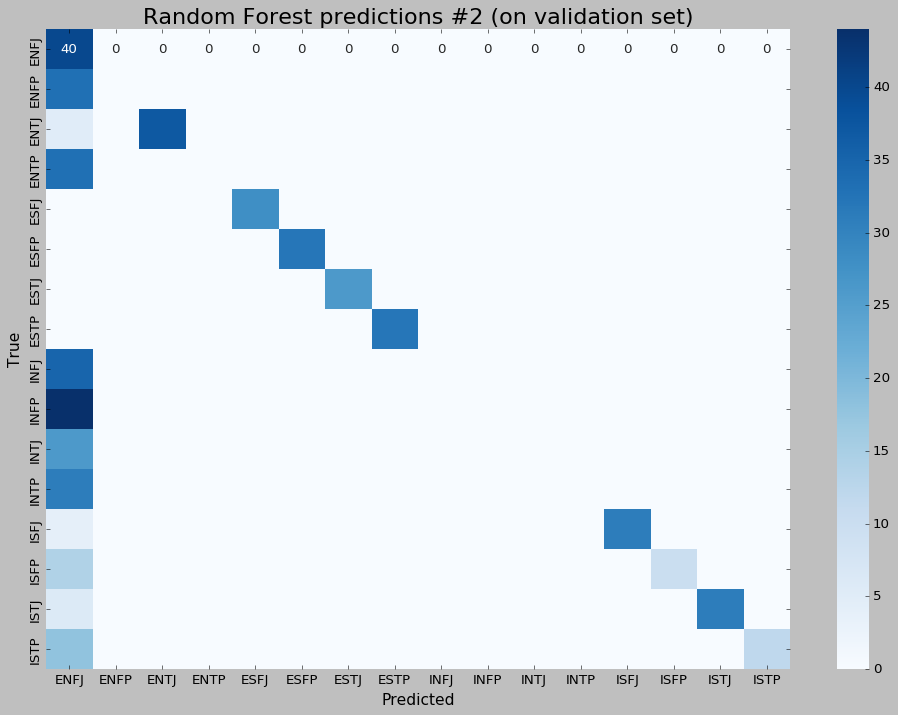

In [1323]:
#cm = confusion_matrix(rf_y_val.values.ravel(), y_pred.ravel())
cm = confusion_matrix(y_true2, y_pred2)

plt.figure(figsize=(15,10))
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = 'g', xticklabels = class_names,
            yticklabels = class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Random Forest predictions #2 (on validation set)', fontsize = 20)
plt.show()

In [1324]:
rf_rep_dict2 = classification_report(y_true2, y_pred2, output_dict = True)
rf_rep2 = pd.DataFrame(rf_rep_dict2)
rf_rep2 = rf_rep2.round(decimals = 2)
rf_rep2.columns = list(class_names) + ['accuracy','macro avg','weighted avg']
#rf_rep2['class'] = mbtis_cap + ['accuracy','macro avg','weighted avg']
#rf_rep2.set_index('class', inplace = True)
rf_rep2

/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ali/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,ESTJ,ESTP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,accuracy,macro avg,weighted avg
precision,0.14,0.0,1.00,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.00,1.00,1.00,1.00,0.53,0.57,0.55
recall,1.00,0.0,0.88,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.89,0.42,0.84,0.40,0.53,0.53,0.53
f1-score,0.24,0.0,0.94,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.94,0.59,0.91,0.57,0.53,0.51,0.50
support,40.00,33.0,42.00,33.0,28.0,32.0,26.0,32.0,35.0,44.0,26.0,31.0,35.00,24.00,37.00,30.00,0.53,528.00,528.00


ENFJ - precision/recall is really messed up
Really bad with ENFP, ENTP, INFJ, INFP, INTJ, INTP
Really good with ENTJ, ESFJ, ESFP, ESTJ, ESTP, ISFJ, ISTJ
Ok with ISFP, ISTP

Maybe need to look again at the resampling factors...

In [1332]:
np.argmax(y_train, axis = 1)

array([ 0,  0, 13, ...,  9,  3,  6])

In [1346]:
# Try assigning weights to RF model
from sklearn.utils.class_weight import compute_class_weight

y_train2_labels = rf_y_train2.apply(lambda x: x.idxmax(), axis = 1).reset_index(drop = True)

class_weights = []

for column in y_train.columns:
    weight = y_train[column].value_counts(normalize=True).to_dict()
    class_weights.append(weight)

rf_weighted = RandomForestClassifier(class_weight = class_weights, random_state = 17,
                                     n_jobs = -1)

rf3 = rf_weighted.fit(rf_X_train2, rf_y_train2)

print(f"Accuracy on train set: {rf3.score(rf_X_train2, rf_y_train2):.4f}")
print(f"Accuracy on validation set: {rf3.score(rf_X_val2, rf_y_val2):.4f}")

Accuracy on train set: 0.9995
Accuracy on validation set: 0.5208


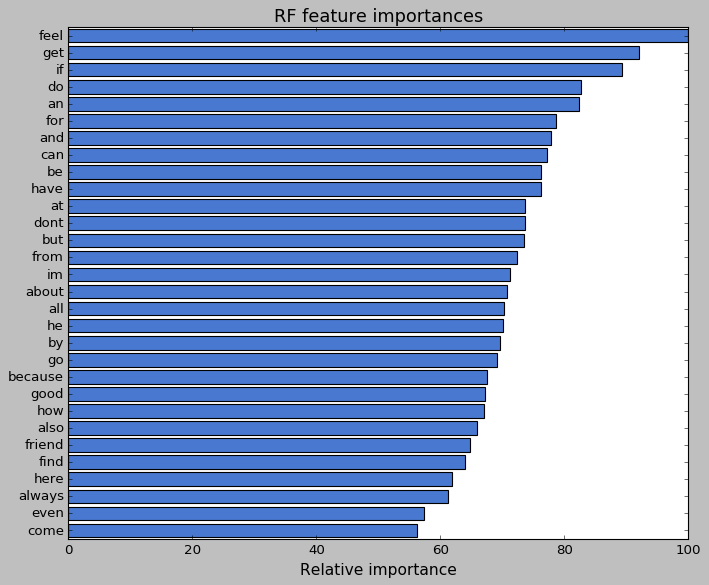

In [1480]:
# Bar chart - feature importances
rf_fi = rf_eda.fit(X_train, y_train).feature_importances_ # Fit on "all" data
rf_fi = 100 * (rf_fi / rf_fi.max())[:30]
idx = np.argsort(rf_fi)[:50]

pos = np.arange(idx.shape[0]) + .5
plt.figure(figsize = (10,8))
plt.barh(pos, rf_fi[idx], align = 'center')
plt.yticks(pos, X.columns[idx])
plt.xlabel('Relative importance')
plt.title('RF feature importances', fontsize = 16)
plt.show();

Feature importance - looks just at the fitted model, not at predictions.
Permutation importance - looks at both training data and predictions.

Feature importances calculated for the RF model built on the 75/25 train/val split. "feel" is far ahead. Also not sure if it's normal that a lot of stopwords appear here?

Permutation importances, which will show which features are most important in generalization by calculating how much the removal (randomization) of a certain feature affects model performance.

In [1347]:
from sklearn.inspection import permutation_importance

# rf3 is fitted to 90% of the training data
result = permutation_importance(rf3, rf_X_val2, rf_y_val2, scoring = 'f1_weighted',
                                n_repeats = 10, random_state = 17, n_jobs = 2)

In [1483]:
sorted_importances = pd.Series(result.importances_mean).sort_values(ascending = False)
perm_idx = sorted_importances.index
top_20 = X_train.columns[sort_idx[:25]]

importances = pd.DataFrame(result.importances).iloc[sort_idx].T
importances.columns = X_train.columns[perm_idx]
importances = importances.iloc[:,:25]
importances = importances.iloc[:, ::-1]
importances

,would,they,do,surprise_e,it,of,to,im,be,so,...,my,but,fear_e,get,your,love,polarity,love_e,type,feel
0,0.00198,0.00000,0.001138,0.000000,0.000962,0.003064,0.000000,0.002201,0.002166,0.00000,...,0.004177,0.002311,0.002044,0.005139,0.007629,0.011752,0.018636,0.015944,0.022700,0.049107
1,0.00198,0.00000,0.000000,0.003064,0.000000,0.000000,0.000000,0.002201,0.001084,0.00198,...,0.000000,0.002220,0.003286,0.004146,0.011092,0.013050,0.015790,0.023974,0.023023,0.042035
2,0.00000,0.00198,0.001138,0.001082,0.000000,0.000000,0.001084,0.000000,0.000000,0.00198,...,0.003064,0.001138,0.004241,0.003128,0.009673,0.009749,0.006322,0.011670,0.029619,0.050936
3,0.00000,0.00198,0.001138,0.000000,0.000000,0.000000,0.002223,0.000000,0.001084,0.00198,...,0.000000,0.000000,0.004026,0.004243,0.007551,0.006663,0.015267,0.014877,0.026112,0.046468
4,0.00198,0.00000,0.000000,0.000000,0.000000,0.000000,0.001084,0.001138,0.001084,0.00198,...,0.000000,0.002201,0.002220,0.007557,0.006457,0.007697,0.013162,0.016932,0.016079,0.050600
5,0.00000,0.00198,0.001138,0.000000,0.000962,0.001084,0.001084,0.000000,0.001084,0.00000,...,0.002046,0.006581,0.004026,0.006507,0.008416,0.016266,0.014824,0.012666,0.023724,0.039369
6,0.00000,0.00000,0.000000,0.001980,0.000962,0.001084,0.000000,0.001138,0.003064,0.00198,...,0.001084,0.002311,0.004200,0.005307,0.007569,0.007838,0.012931,0.012632,0.025812,0.046354
7,0.00000,0.00000,0.001138,0.001082,0.004058,0.001980,0.002166,0.001138,0.001084,0.00000,...,0.001980,0.001138,0.006223,0.007830,0.006277,0.010895,0.011678,0.011490,0.023603,0.053976
8,0.00000,0.00000,0.001138,0.000000,0.000000,0.001084,0.000000,0.001063,0.000000,0.00000,...,0.001084,0.004291,0.002025,0.007139,0.009740,0.012055,0.014017,0.019040,0.023674,0.039851
9,0.00000,0.00000,0.000000,0.000000,0.000962,0.000000,0.001084,0.000000,0.001084,0.00198,...,0.003064,0.001138,0.006399,0.002046,0.006551,0.008927,0.016119,0.015694,0.017819,0.040782


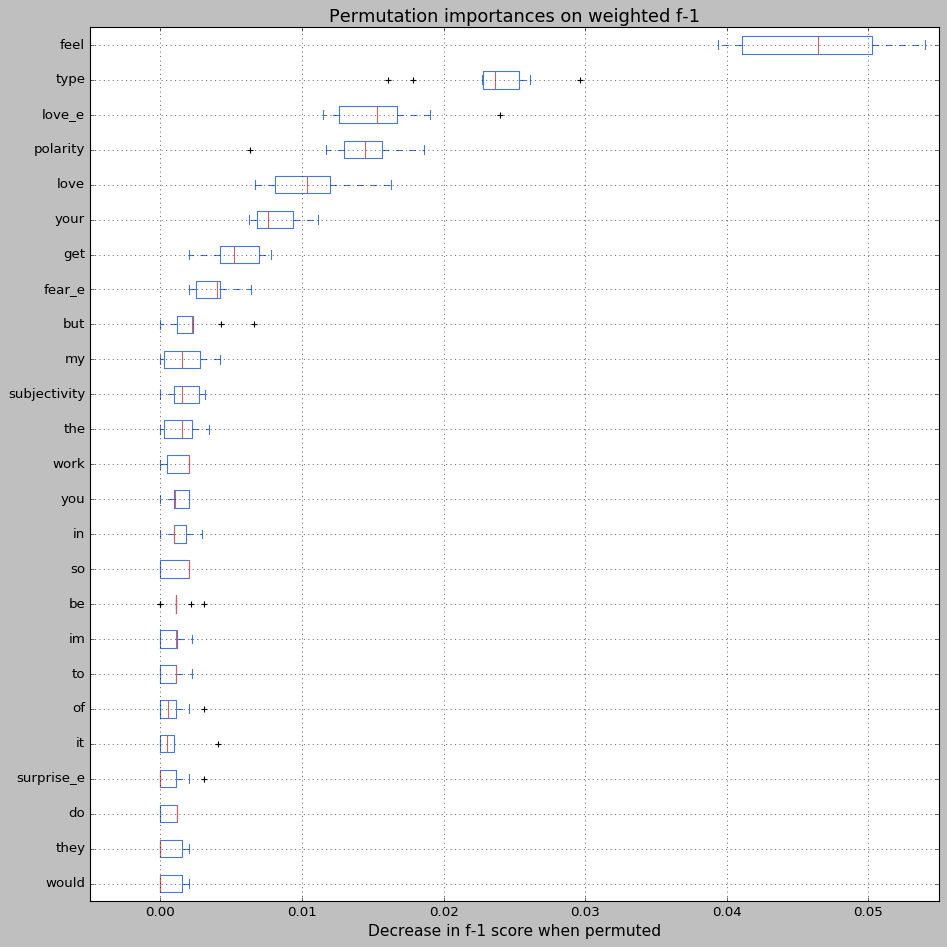

In [1478]:
# Boxplot
ax = importances.plot.box(vert = False, figsize = (12,12), grid = True)
ax.set_title("Permutation importances on weighted f-1", fontsize = 16)
ax.set_xlabel("Decrease in f-1 score when permuted")
ax.set_xlim(-0.005, .055)
ax.figure.tight_layout()

In [1496]:
feat_importance = pd.Series(X.columns[idx][:20])
perm_importance = pd.Series(X.columns[perm_idx][:20])
importance_comparisons = pd.DataFrame([feat_importance, perm_importance]).T
importance_comparisons.columns = ['feature', 'permutation']
importance_comparisons

,feature,permutation
0,come,feel
1,even,type
2,always,love_e
3,here,polarity
4,find,love
5,friend,your
6,also,get
7,how,fear_e
8,good,but
9,because,my


No commonalities in top 20.

Next: Try a model predicting cognitive functions rather than 4-letter type

Quiz: After each question, reapply model? (slow?)

Sort by highest probability and try to determine type
-highest probabilty = dominant - will be either e or i oriented
-second highest *with the opposite orientation* = auxiliary
-third highest *with the opposite orientation* = tertiary
-fourth highest *with the opposite orientation* = inferior

ie. train model on text data with each function scored 0 (not present) to 4
-dominant: 4, auxiliary: 3, tertiary: 2, inferior: 1
-predict probability on all 8 functions, then apply sorting/selection method outlined above

-after each is selected, no other of that function (I, F, T, S) can be selected again

ex. Ni = 3.9, Ne = 3.8, Fe = 3.6, Te = 3.2, Se = 3.1, Si = 2.8, Fi = 2.3, Ti = 2.1

-would first select Ni, then Fe, then Si... but then needs to go back? if it cannot another in the opposite orientation
-so this output = Ni Fe Si Te which is not a known configuration, so the user would need to answer more questions
-then maybe they get:
    Ni = 3.7, Fe = 3.6, Te = 3.2, Ti = 3.1, Si = 2.8, Se = 2.5, Fi = 2.1, Ne = 1.2
-would be = Ni Fe Ti Se which is INFJ

Need to test to see if this would even work... how would I?

IF 4 letter combination matches a known type, problem solved. Otherwise, the user will need to answer another question.

First 3 questions need responses - first 3 questions need to be really good...
How many questions will need to be written? Can questions be autogenerated... or if questions are predefined, maybe response options can be autogenerated? (based on what?)

# Class normalization

In [ ]:
# Loop over coefficient c to calculate best distribution
c_vals = [np.round(c, 3) for c in np.linspace(0.01, .99, 10)]
mean_class_size = int(sum([len(cls) for cls in posts_bytype]) / len(posts_bytype))

normalized_data = []

for c in c_vals:
    for mbti_type in posts_bytype:
        class_size = len(mbti_type)
        difference = class_size - mean_class_size
        k = c * difference
        if class_size > mean_class_size:
            norm_class_size = int(class_size - k)
            re_sample = resample(mbti_type, replace = True, n_samples = norm_class_size,
                                 random_state = 17)
        else:
            norm_class_size = int(class_size - k)
            re_sample = resample(mbti_type, replace = True, n_samples = norm_class_size,
                                 random_state = 17)
        normalized_data.append(re_sample)
        print('c =', c, 'class_size =', class_size, 'normalized =', len(re_sample))

In [ ]:
normalized_classes = mbtis * 10
normalized_class_sizes = [len(t) for t in normalized_data]
normalization_tests_df = pd.DataFrame([normalized_classes, np.repeat(c_vals, 16), normalized_class_sizes]).T
normalization_tests_df.columns = ['type', 'c', 'norm_size']
normalization_tests_df.tail()

In [ ]:
tfidf_bal = pd.concat([tfidf, encoded_label_df], axis = 1)
train_scores = []
test_scores = []

for c in c_vals:
    # pd.Series of distributions for current value of c
    distribution = normalization_tests_df[normalization_tests_df['c'] == c].norm_size
    downsampled_data = []
    upsampled_data = []
    
    # Loop through each MBTI dataset
    for i in range(len(posts_bytype)):
        if len(posts_bytype[i]) > mean_class_size:
            re_sample = resample(posts_bytype[i], replace = False,
                                 n_samples = distribution.iloc[i], random_state = 17)
            downsampled_data.append(re_sample)
        else:
            re_sample = resample(posts_bytype[i], replace = True,
                                 n_samples = distribution.iloc[i], random_state = 17)
            upsampled_data.append(re_sample)
    
        # Convert list of frames to dataframe
        downsampled_data_df = pd.concat(downsampled_data, ignore_index = True)

        upsampled_tfidf_ls = []

        # Manually append data for upsampling (resampled with replacement)
        for x in upsampled_data:
            for i in x.index:
                new_sample = tfidf_bal.loc[i]
                upsampled_tfidf_ls.append(new_sample)

        # Convert list of frames to dataframe
        df = pd.DataFrame(upsampled_tfidf_ls)
        # Concat with downsampled data
        df = pd.concat([df, tfidf_bal[tfidf_bal.index.isin(downsampled_data_df.index)]],
                       axis = 0, ignore_index = True)

    # Create X and y for modeling, where X is all tfidf data except label and types
    # and y is one-hot encoded types
    X = df.drop(['label'] + mbtis_cap, axis = 1).reset_index(drop = True)
    y = df.iloc[:,-16:]

    # TypeError on column types?
#    X.columns = X.columns.astype(str)
#    y.columns = y.columns.astype(str)

    # Initial train/test split (to preserve unseen data on each distribution)
    X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X, y,
                                                                            test_size = .2, stratify = y,
                                                                            random_state = 17)

    # Train/test split for scoring
    X_train, X_test, y_train, y_test = train_test_split(X_train_init, y_train_init,
                                                        test_size = .2, stratify = y_train_init,
                                                        random_state = 17)

    # Initialize and fit model
    model = RandomForestClassifier(random_state = 17, n_jobs = -1)
    model.fit(X_train, y_train)
    
    # Print c and scores for each 
    print(c)
    print(f"Accuracy on train set: {model.score(X_train, y_train):.4f}")
    print(f"Accuracy on test set: {model.score(X_test, y_test):.4f}")
    
    train_scores.append(np.round(model.score(X_train, y_train), 4))
    test_scores.append(np.round(model.score(X_test, y_test), 4))

In [ ]:
c_scores_df = pd.DataFrame([c_vals, train_scores, test_scores]).T
c_scores_df.columns = ['c', 'train_score', 'test_score']
c_scores_df

In [ ]:
c_scores_df.plot(x = 'c', y = 'test_score', ylabel = 'Accuracy', figsize = (12,8),
                 legend = False, grid = True)
plt.title('Coefficient-based class normalization', fontsize = 18);

In [ ]:
# Copied from for loop above
downsampled_data = []
upsampled_data = []

class_size = len(mbti_type)
difference = class_size - mean_class_size
k = c * difference
if class_size > mean_class_size:
    norm_class_size = int(class_size - k)
    re_sample = resample(mbti_type, replace = True, n_samples = norm_class_size,
                         random_state = 17)
else:
    norm_class_size = int(class_size - k)
    re_sample = resample(mbti_type, replace = True, n_samples = norm_class_size,
                         random_state = 17)
normalized_data.append(re_sample)

# Loop through each MBTI dataset
for i in range(len(posts_bytype)):
    class_size = len(posts_bytype[i])
    difference = abs(class_size - mean_class_size)
    c = .99
    k = c * difference
    if class_size > mean_class_size:
        norm_class_size = int(class_size - k)
        re_sample = resample(posts_bytype[i], replace = False,
                             n_samples = norm_class_size, random_state = 17)
        downsampled_data.append(re_sample)
    else:
        re_sample = resample(posts_bytype[i], replace = True,
                             n_samples = norm_class_size, random_state = 17)
        upsampled_data.append(re_sample)

    # Convert list of frames to dataframe
    downsampled_data_df = pd.concat(downsampled_data, ignore_index = True)

    upsampled_tfidf_ls = []

    # Manually append data for upsampling (because resampled with replacement)
    for x in upsampled_data:
        for i in x.index:
            new_sample = tfidf_bal.loc[i]
            upsampled_tfidf_ls.append(new_sample)

    # Convert list of frames to dataframe
    df = pd.DataFrame(upsampled_tfidf_ls)
    # Concat with downsampled data
    df = pd.concat([df, tfidf_bal[tfidf_bal.index.isin(downsampled_data_df.index)]],
                   axis = 0, ignore_index = True)

# Create X and y for modeling, where X is all tfidf data except label and types
# and y is one-hot encoded types
X = df.drop(['label'] + mbtis_cap, axis = 1).reset_index(drop = True)
y = df.iloc[:,-16:]

# Initial train/test split (to preserve unseen data on each distribution)
X_train_init, X_test_init, y_train_init, y_test_init = train_test_split(X, y,
                                                                        test_size = .2, stratify = y,
                                                                        random_state = 17)

# Train/test split for model selection
X_train, X_test, y_train, y_test = train_test_split(X_train_init, y_train_init,
                                                    test_size = .2, stratify = y_train_init,
                                                    random_state = 17)

# Initialize and fit first model, Random Forest
model = RandomForestClassifier(random_state = 17, n_jobs = -1)
model.fit(X_train, y_train)

print("Random Forest, untuned")
print(f"Accuracy on train set: {model.score(X_train, y_train):.4f}")
print(f"Accuracy on test set: {model.score(X_test, y_test):.4f}")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

print("K-nearest neighbors, untuned")
print(f"Accuracy on train set: {knn_model.score(X_train, y_train):.4f}")
print(f"Accuracy on test set: {knn_model.score(X_test, y_test):.4f}")

In [ ]:
from sklearn.naive_bayes import MultinomialNB
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

print("Multinomial Naive Bayes, untuned")
print(f"Accuracy on train set: {nb_model.score(X_train, y_train):.4f}")
print(f"Accuracy on test set: {nb_model.score(X_test, y_test):.4f}")

In [ ]:
from sklearn.neural_network import MLPClassifier 
score = 0
iterations = np.linspace(500, 25000, 15)

for max_iter in iterations:
    while score < .6:    
        nn_model = MLPClassifier(max_iter = int(max_iter))
        nn_model.fit(X_train, y_train)
        
    score = nn_model.score(X_test, y_test)

print("Multilayer perceptron classifier, untuned")
print(f"Accuracy on train set: {nn_model.score(X_train, y_train):.4f}")
print(f"Accuracy on test set: {nn_model.score(X_test, y_test):.4f}")